In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def plot_samples(generator, image_name, nrows=3, ncols=6):
    # Shuffle the data indices
    indices = np.arange(len(generator[0][0]))
    np.random.shuffle(indices)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 12))
    idx = 0

    for i in range(nrows):
        for j in range(ncols):
            sample_idx = indices[idx]
            label = labels[np.argmax(generator[0][1][sample_idx])]
            ax[i, j].set_title(f"{label}")
            ax[i, j].imshow(generator[0][0][sample_idx][:, :, :])
            ax[i, j].axis("off")
            idx += 1

    plt.tight_layout()
    plt.suptitle("Sample Training Images", fontsize=21)
    plt.show()

In [28]:
def plot_history(train_acc, val_acc, train_loss, val_loss, epochs, image_name):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.savefig(image_name + ' - History.jpg', dpi=300, format='jpg')
    plt.show()

In [35]:
from sklearn.metrics import roc_curve, auc

def plot_auc(validation_generator, y_pred_prob, image_name):
    fpr, tpr, _ = roc_curve(validation_generator.classes, y_pred_prob[:, 0])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 10))
    lw = 2
    plt.plot(fpr, tpr, color='blue', lw=lw, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    
    plt.savefig(image_name + ' - History.jpg', dpi=300, format='jpg')
    plt.show()

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def plot_cm(validation_generator, y_pred, image_name):
    labels = validation_generator.class_indices.keys()
    cm = confusion_matrix(validation_generator.classes, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    plt.figure(figsize=(16, 12))
    disp.plot(cmap=plt.cm.Blues, values_format="d", xticks_rotation='vertical')
    
    plt.savefig(image_name + ' - Confustion Matrix.jpg', dpi=300, format='jpg')
    plt.show()

In [6]:
dataset_path = "/kaggle/input/cataract/"

In [7]:
labels = sorted(os.listdir(dataset_path))

In [8]:
IMG_WIDTH = 96
IMG_HEIGHT = 96
BATCH_SIZE = 16
n_classes = 1
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

In [10]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2,
    rotation_range=20, 
    horizontal_flip=True,   
    brightness_range=[0.8, 1.2]
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

Found 538 images belonging to 2 classes.


In [11]:
validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

validation_generator = validation_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=1,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 133 images belonging to 2 classes.


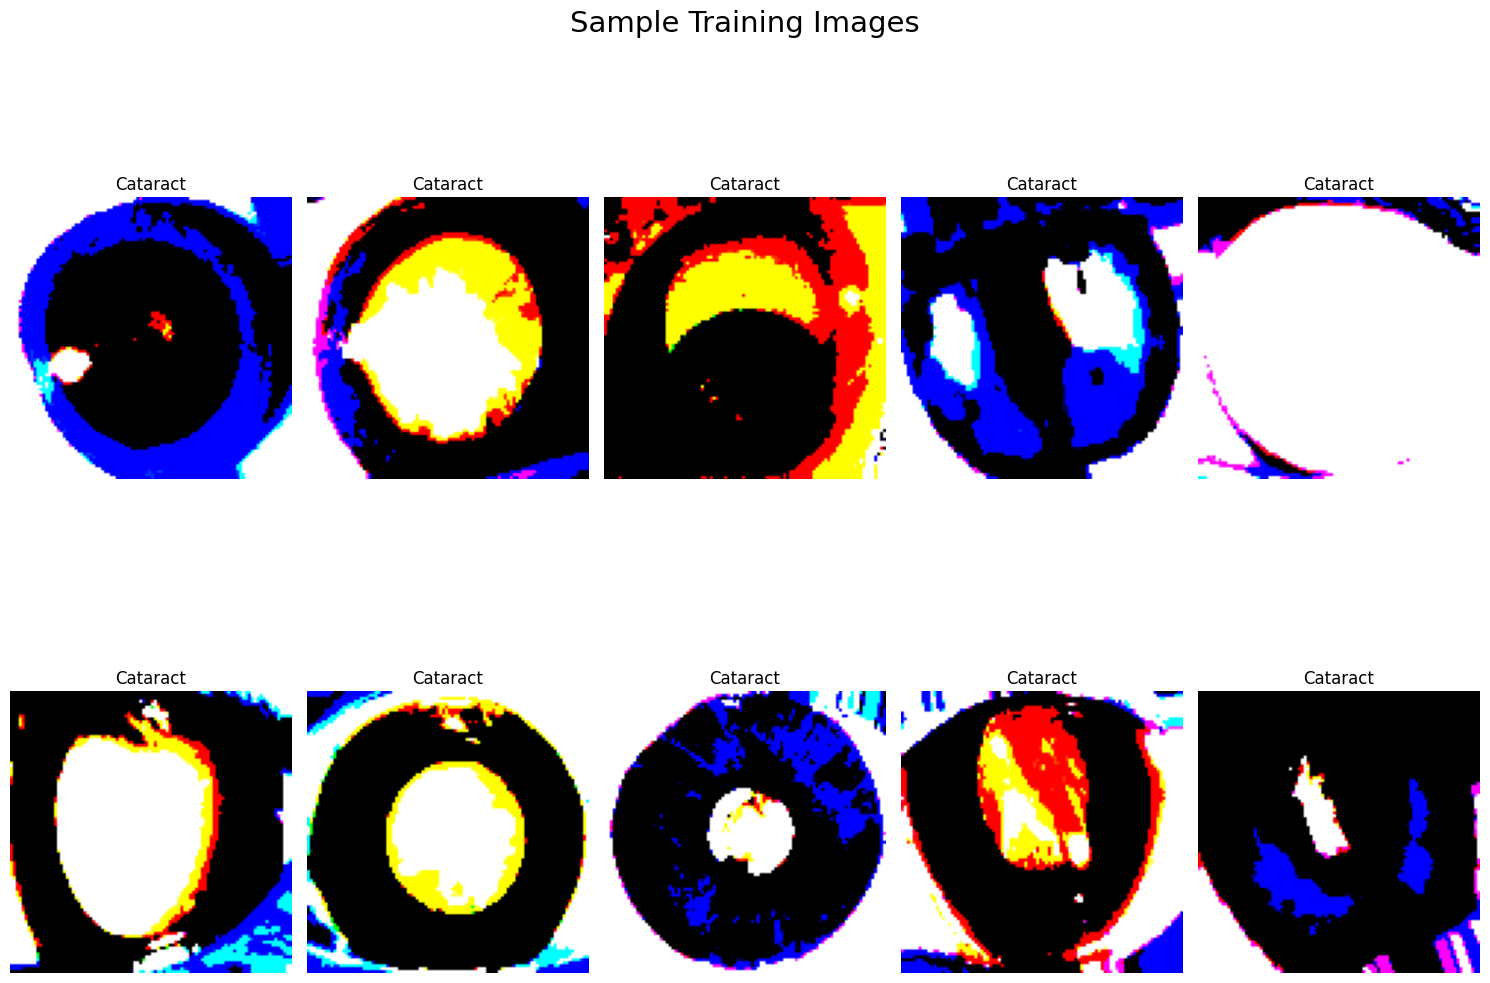

In [12]:
plot_samples(train_generator, "Custom CNN", 2, 5)

In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2), strides=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [14]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 64)        0

In [16]:
history = model.fit(
    train_generator, 
    epochs=10, 
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
34/34 [==============================] - 19s 233ms/step - loss: 3.1818 - accuracy: 0.8030 - val_loss: 0.1994 - val_accuracy: 0.9173 - lr: 0.0010
Epoch 2/10
34/34 [==============================] - 5s 154ms/step - loss: 0.2629 - accuracy: 0.9182 - val_loss: 0.1516 - val_accuracy: 0.9549 - lr: 0.0010
Epoch 3/10
34/34 [==============================] - 5s 152ms/step - loss: 0.1697 - accuracy: 0.9480 - val_loss: 0.1417 - val_accuracy: 0.9624 - lr: 0.0010
Epoch 4/10
34/34 [==============================] - 5s 154ms/step - loss: 0.1602 - accuracy: 0.9535 - val_loss: 0.1773 - val_accuracy: 0.9173 - lr: 0.0010
Epoch 5/10
34/34 [==============================] - 5s 157ms/step - loss: 0.1137 - accuracy: 0.9610 - val_loss: 0.2108 - val_accuracy: 0.9398 - lr: 0.0010
Epoch 6/10
34/34 [==============================] - 5s 147ms/step - loss: 0.1126 - accuracy: 0.9628 - val_loss: 0.1725 - val_accuracy: 0.9699 - lr: 2.0000e-04
Epoch 7/10
34/34 [==============================] - 5s 154ms/step

In [16]:
history = model.fit(
    train_generator, 
    epochs=30, 
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
34/34 [==============================] - 17s 259ms/step - loss: 0.9117 - accuracy: 0.8086 - val_loss: 0.4046 - val_accuracy: 0.8722 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - 6s 190ms/step - loss: 0.4160 - accuracy: 0.8736 - val_loss: 0.4528 - val_accuracy: 0.8647 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - 7s 193ms/step - loss: 0.2245 - accuracy: 0.9182 - val_loss: 0.1767 - val_accuracy: 0.9474 - lr: 0.0010
Epoch 4/30
34/34 [==============================] - 7s 194ms/step - loss: 0.1798 - accuracy: 0.9331 - val_loss: 0.2293 - val_accuracy: 0.9173 - lr: 0.0010
Epoch 5/30
34/34 [==============================] - 6s 185ms/step - loss: 0.1458 - accuracy: 0.9498 - val_loss: 0.2626 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 6/30
34/34 [==============================] - 6s 189ms/step - loss: 0.1443 - accuracy: 0.9517 - val_loss: 0.1846 - val_accuracy: 0.9474 - lr: 2.0000e-04
Epoch 7/30
34/34 [==============================] - 6s 190ms/step

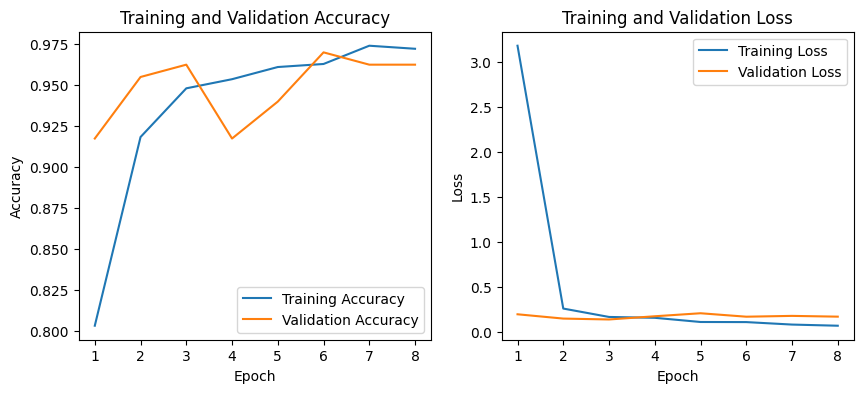

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
    
plot_history(acc, val_acc, loss, val_loss, epochs, "Custom CNN")

In [17]:
predict = model.predict(validation_generator)
# predict the class label
y_classes = predict.ravel().round()
y_classes

133/133 [==============================] - 1s 6ms/step


array([0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

133/133 [==============================] - 1s 6ms/step - loss: 0.1417 - accuracy: 0.9624
Test accuracy: 0.9624


<Figure size 1600x1200 with 0 Axes>

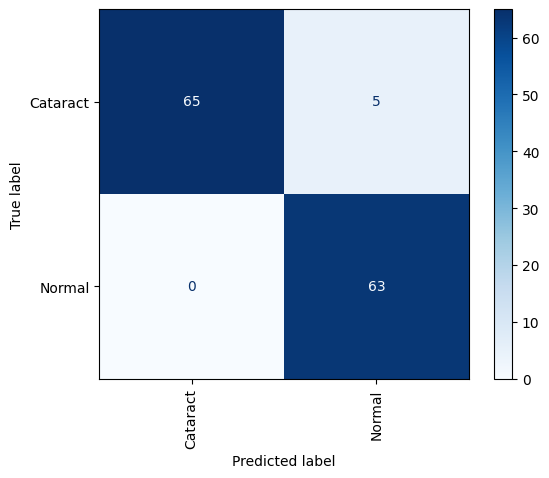

In [33]:
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test accuracy: {test_accuracy:.4f}")

plot_cm(validation_generator, y_classes, "Custom CNN");

In [38]:
print(classification_report(validation_generator.classes, y_classes))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        70
           1       0.93      1.00      0.96        63

    accuracy                           0.96       133
   macro avg       0.96      0.96      0.96       133
weighted avg       0.97      0.96      0.96       133



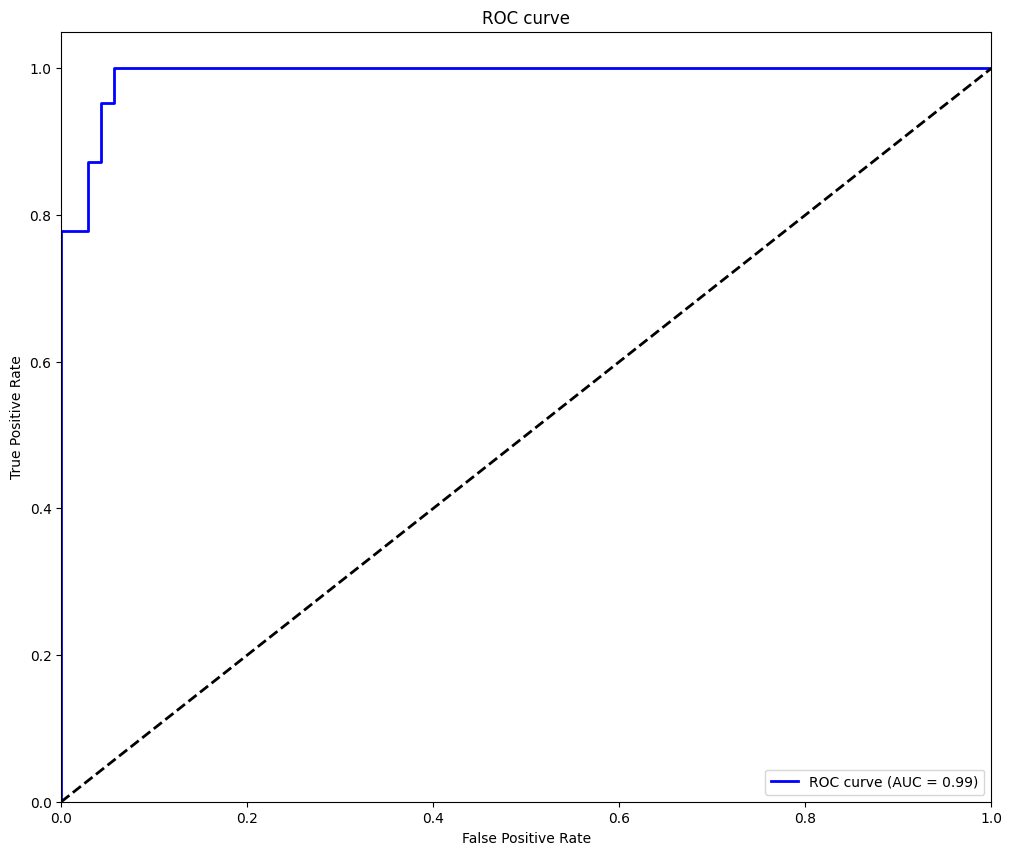

In [36]:
plot_auc(validation_generator, predict, "Custom CNN")

In [20]:
model.save('model-96.26%.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
